In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

import matplotlib.pyplot as plt

import numpy as np
from qtconsole.mainwindow import background

from Utils.models import *
from Utils.simulation import *
from Utils.plot_utils import *

import time
from copy import copy

%load_ext autoreload
%autoreload 2

In [1]:
import json

# Create a dictionary to store the parameters
params_dict = {
    "dataset_parameters": {
        "n_samples": 200
    },
    "network_parameters": {
        "input_size": 2**6,
        "hidden_size": 2**7,
        "output_size": 1,
        "bias": 1,
    },
    "training_parameters": {
        "num_epochs": 50,
        "learning_rate": 0.1
    },
    "simulation_parameters": {
        "mu": 1,
        "sigma": 0.1,
        "theta": 0.05,
        "dt": 0.001
    },
    "seed": 42
}

# Save the dictionary as a JSON file
# with open('simulation_parameters.json', 'w') as json_file:
#     json.dump(params_dict, json_file, indent=4)
rng = random.key(params_dict["seed"])

NameError: name 'random' is not defined

In [3]:
mu_LN = mu_LN_from_params(**params_dict["simulation_parameters"])
sigma_LN = sigma_LN_from_params(**params_dict["simulation_parameters"])

rng, net_key = random.split(rng)
base_params = init_mlp(net_key, mu_LN, sigma_LN, **params_dict["network_parameters"])

In [4]:
rng, data_key = random.split(rng)

X_train, y_train = create_binary_dataset(data_key, n_samples=params_dict["dataset_parameters"]["n_samples"], input_dim=params_dict["network_parameters"]["input_size"])

In [12]:
sigmas_list = [0, 0.1, 0.2, 0.5, 1]

training_parameters = params_dict["training_parameters"]
num_epochs = training_parameters["num_epochs"]
learning_rate = training_parameters["learning_rate"]
simulation_parameters = params_dict["simulation_parameters"]

total_acc_list = []

for sig in sigmas_list:
    simulation_parameters["sigma"] = sig
    params=copy(base_params)
    
    print("Sigma: ", sig)
    
    acc_list = []
    for epoch in range(num_epochs):
        start_time = time.time()
        for x,y in zip(X_train,y_train):
    
            rng, gou_key = random.split(rng)
    
            grads = grad(loss_mlp)(params, x, y)
            params['W_i'] -= learning_rate*grads['W_i']
            params['W_h'] -= learning_rate*grads['W_h']-perturb_GOU(gou_key, params['W_h'],  **simulation_parameters )
            params['W_o'] -= learning_rate*grads['W_o']
    
    
    
    
        acc_list.append(accuracy_mlp(params, X_train, y_train))
       
    

        if epoch%10==0:
            epoch_time = time.time() - start_time
            train_loss = loss_mlp(params, X_train, y_train)
            train_acc = accuracy_mlp(params, X_train, y_train)
            print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
            print("Training set loss {}".format(train_loss))
            print("Training set accuracy {}".format(train_acc))


    for epoch in range(num_epochs):
        start_time = time.time()
        for x,y in zip(X_train,y_train):
    
    
            rng, gou_key = random.split(rng)
            params['W_h'] += perturb_GOU(gou_key, params['W_h'],  **simulation_parameters )
    
        acc_list.append(accuracy_mlp(params, X_train, y_train))
    
        if epoch%10==0:
            epoch_time = time.time() - start_time
            train_loss = loss_mlp(params, X_train, y_train)
            train_acc = accuracy_mlp(params, X_train, y_train)
            print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
            print("Test set loss {}".format(train_loss))
            print("Test set accuracy {}".format(train_acc))
            
    total_acc_list.append(acc_list)

Sigma:  0
Epoch 0 in 3.76 sec
Training set loss 2.760960578918457
Training set accuracy 0.550000011920929
Epoch 10 in 3.26 sec
Training set loss 0.904561460018158
Training set accuracy 0.75
Epoch 20 in 3.24 sec
Training set loss 0.6486820578575134
Training set accuracy 0.7899999618530273
Epoch 30 in 3.28 sec
Training set loss 0.3420526385307312
Training set accuracy 0.8849999904632568
Epoch 40 in 3.26 sec
Training set loss 0.0013682972639799118
Training set accuracy 1.0
Epoch 0 in 0.23 sec
Test set loss 0.0008464914280921221
Test set accuracy 1.0
Epoch 10 in 0.22 sec
Test set loss 0.0008585884352214634
Test set accuracy 1.0
Epoch 20 in 0.22 sec
Test set loss 0.0008718660101294518
Test set accuracy 1.0
Epoch 30 in 0.23 sec
Test set loss 0.0008863371913321316
Test set accuracy 1.0
Epoch 40 in 0.22 sec
Test set loss 0.0009021119331009686
Test set accuracy 1.0
Sigma:  0.1
Epoch 0 in 3.24 sec
Training set loss 2.7820653915405273
Training set accuracy 0.550000011920929
Epoch 10 in 3.21 sec
T

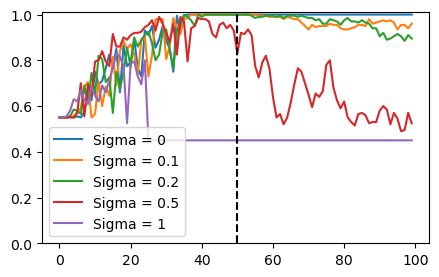

In [17]:
# Plot the results
plt.figure(figsize=(5,3))
for i in range(len(sigmas_list)):
    plt.plot(total_acc_list[i], label=f'Sigma = {sigmas_list[i]}')
#plt.plot(total_acc_list[2], label=f'Sigma = {sigmas_list[2]}')
#plt.xlabel('Epoch')
#plt.ylabel('Accuracy'), 
plt.ylim([0.,1.01])
plt.legend()
#plot a vertical line at the end of the training phase
plt.axvline(x=num_epochs, color='k', linestyle='--')
plt.savefig('accuracy_vs_epoch.png', dpi=1000, bbox_inches='tight', transparent=True)
plt.show()
